# Custom Layers in Keras

# Task 1: Importing Libraries

In [6]:
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.0.0-beta1


# Task 2: Import and Visualize Dataset

In [9]:
#instead of below two cells can directly do (x_train, y_train), (x_test, y_test)=utils.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [10]:
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255. #the pixel values are normalized,each row represnts one image
print(x_train.shape)
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
y_train = tf.keras.utils.to_categorical(y_train)  #one hot encoding
y_test = tf.keras.utils.to_categorical(y_test)

(60000, 28, 28)
(60000, 784)


In [11]:
#instead of below two cells can directly do utils.plot_random_exapmles(x_train,y_train).show()
def plot_random_examples(x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10)
    y = np.argmax(y, axis=1)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Ajinkeya\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

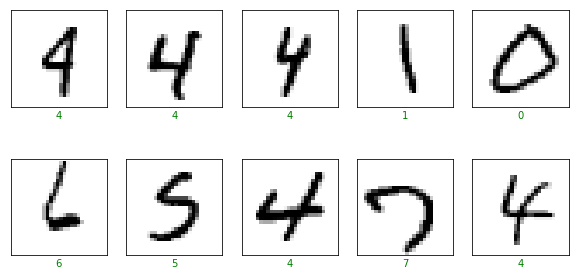

In [12]:
plot_random_examples(x_train,y_train) #p=y_train 

# Task 3: Creating a Custom Layer

In [16]:
#to create a custom activation layer must create it as a child class of keras class
#we want to create a parametric relu layer,in normal leku relu layer parameter alpha is set but in parametric relu the alpha is learnt.
#need to implement three functions:
#1) build:define any trainable weights
#2) call:logic of Custoom Layer
#3) compute output shape:transformation logic of layers for any change in shape happening in layer

class ParametricRelu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  #we wont set any initial value for variables i.e. alpha
        super(ParametricRelu, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.alpha=self.add_weight(     #trainable parameter
          name='alpha',shape=(1,),       #(1,) means same alpha value for each node of the layer, if wwe want different alpha values for each node of the layer then shape=(input_shape[1],) where input_shape[0] is no of exsmples and 1 is no of nodes
          initializer='zeros',         #all nodes given initial value 0
          trainable='True'  )
        super(ParametricRelu, self).build(input_shape)  #call build fuunction on superclass
        
    def call(self, x):
        return tf.maximum(0., x) + self.alpha*tf.minimum(0., x) #first term is for positive x values and second term for negative x values
    

# Task 4: Creating the Model

In [18]:
def create_model(use_prelu=True):
    model=tf.keras.models.Sequential()
    #layer 1 with 64 nodes
    model.add(tf.keras.layers.Dense(64, input_shape=(784,)))
    #activation of layer 1
    if use_prelu:
        model.add(ParametricRelu())
    else:
        model.add(tf.keras.layers.ReLU())
    #output layer with 10 nodes
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
model=create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
parametric_relu_2 (Parametri (None, 64)                1         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 50,891
Trainable params: 50,891
Non-trainable params: 0
_________________________________________________________________


# Task 5: Model Training

In [20]:
print('Initial alpha: ',model.layers[1].get_weights())

h=model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=5
)

Initial alpha:  [array([0.], dtype=float32)]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 59s 983us/sample - loss: 0.2922 - accuracy: 0.9179 - val_loss: 0.1448 - val_accuracy: 0.9576
Epoch 2/5
60000/60000 [==============================] - 28s 459us/sample - loss: 0.1226 - accuracy: 0.9636 - val_loss: 0.1071 - val_accuracy: 0.9678
Epoch 3/5
60000/60000 [==============================] - 28s 470us/sample - loss: 0.0857 - accuracy: 0.9743 - val_loss: 0.1022 - val_accuracy: 0.9688
Epoch 4/5
60000/60000 [==============================] - 28s 464us/sample - loss: 0.0675 - accuracy: 0.9794 - val_loss: 0.0969 - val_accuracy: 0.9695
Epoch 5/5
60000/60000 [==============================] - 27s 453us/sample - loss: 0.0544 - accuracy: 0.9832 - val_loss: 0.0865 - val_accuracy: 0.9727


In [21]:
print('Final alpha: ',model.layers[1].get_weights())
#thus if x>0 then y=x and if x<0 then also y is >0 and nearly =|x|

Final alpha:  [array([-0.9203072], dtype=float32)]


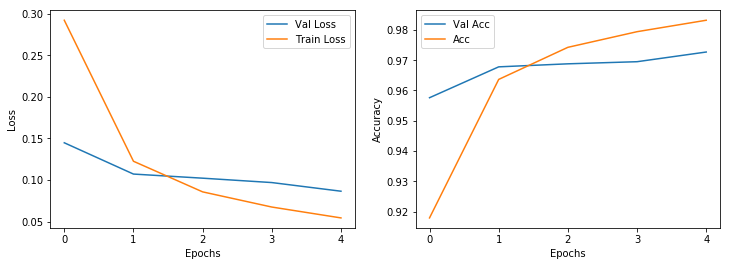

In [23]:
history = h.history
plt.figure(figsize=(12, 4))
epochs = len(history['val_loss'])
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['val_loss'], label='Val Loss')
plt.plot(range(epochs), history['loss'], label='Train Loss')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['val_accuracy'], label='Val Acc')
plt.plot(range(epochs), history['accuracy'], label='Acc')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Task 6: Comparison with ReLU

In [24]:
model=create_model(use_prelu=False)
model.summary()
#no trainable parameteer in Relu layer

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [25]:
h=model.fit(x_train,y_train,
           validation_data=(x_test,y_test),
           epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 38s 640us/sample - loss: 0.2952 - accuracy: 0.9164 - val_loss: 0.1686 - val_accuracy: 0.9508
Epoch 2/5
60000/60000 [==============================] - 32s 529us/sample - loss: 0.1419 - accuracy: 0.9581 - val_loss: 0.1353 - val_accuracy: 0.9591
Epoch 3/5
60000/60000 [==============================] - 26s 441us/sample - loss: 0.1053 - accuracy: 0.9687 - val_loss: 0.1085 - val_accuracy: 0.9668
Epoch 4/5
60000/60000 [==============================] - 21s 358us/sample - loss: 0.0837 - accuracy: 0.9744 - val_loss: 0.1036 - val_accuracy: 0.9710
Epoch 5/5
60000/60000 [==============================] - 27s 452us/sample - loss: 0.0694 - accuracy: 0.9790 - val_loss: 0.0940 - val_accuracy: 0.9713


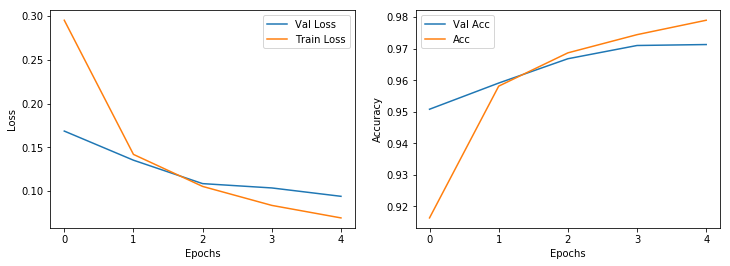

In [26]:
history = h.history
plt.figure(figsize=(12, 4))
epochs = len(history['val_loss'])
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['val_loss'], label='Val Loss')
plt.plot(range(epochs), history['loss'], label='Train Loss')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['val_accuracy'], label='Val Acc')
plt.plot(range(epochs), history['accuracy'], label='Acc')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [34]:
def show_random_examples(x, y, p):   #x,y are inputs and p is prediciton if any
    indices=np.random.choice(range(x.shape[0]), 10, replace=False)  #we only want 10 random examples from list of all indices and they will be unique 
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i].reshape(28,28),cmap='binary')
        plt.xticks([])
        plt.yticks([])
        #color of label green if prediction right else red
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'  #np.argmax will reurn 0,1 or 2 from one hot econded format of each label indicating which of the three classes it is
        plt.xlabel(np.argmax(y[i]),color=col)
    plt.show()   

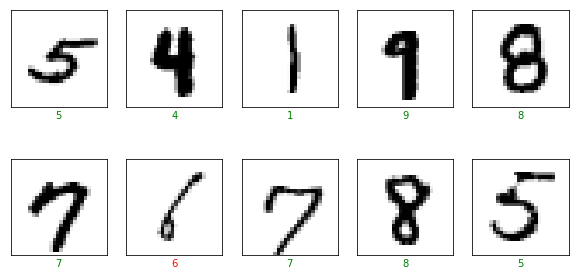

In [36]:
show_random_examples(x_test,y_test,p=model.predict(x_test))